# Data Processing Pipeline for beautofuel

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import geopy.distance

from packages.envirocar import TrackAPI, BboxSelector, TimeSelector, ECConfig
from packages.eda_quality import correction as correct
from packages.eda_quality import manipulation as manipulate
from packages.eda_quality import inspection as inspect
from packages.vehicle_eco_balance import get_interval_time

## Pipeline configuration

In [2]:
# How many days behind to look for tracks
days_to_look_back=120

# User
config = ECConfig(username="samko", password="someamazingtotallyrandomtoken")

track_api = TrackAPI()

## Tracks fetching

<AxesSubplot:>

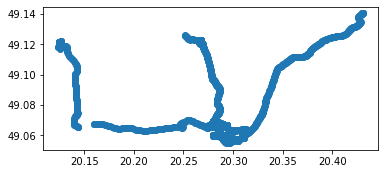

In [3]:
# Boundary box for Slovakia
bbox = BboxSelector([
    16.76425013529685, # min_x
    47.37325224412486, # min_y
    22.594816079401987, # max_x
    49.7297265173567 # max_y
])

# Tracks time interval
datetime_format = "%Y-%m-%dT%H:%M:%S+00:00"
start_time = datetime.today() - timedelta(days=days_to_look_back)
end_time = datetime.now()
time_interval = TimeSelector(start_time=start_time.strftime(datetime_format), end_time=end_time.strftime(datetime_format))

# Fetch from enviroCar API
tracks_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval)

tracks_df.plot()

## Data cleaning and pre-processing

In [4]:
# Drop duplicated rows
tracks_df = correct.drop_duplicates(tracks_df)

# Remove tracks that exceed 8 hours of duration time
_, tracks_df, _ = correct.exceed_eight_hours(tracks_df, flag=False)

# Remove tracks that falls below x minutes of duration time
_, tracks_df, _ = correct.below_x_min(tracks_df, x=3, flag=False)

# Remove tracks that exceed 250 km/h speed
_, tracks_df, _ = correct.implausible_max_speed(tracks_df, flag=False)

# Drop unit colums since we are not interested in them
manipulate.drop_unit_columns(tracks_df).head()

track_ids = tracks_df['track.id'].unique()

# interpolated_tracks_df=None

# Interpolate every track
# TODO Interpolate only missing data (e.g. track ID 6002d1a1886b71633cdd2fc9)
# for track_id in track_ids:
#     track_df = inspect.get_single_track(tracks_df, track_id)

#     track_df = manipulate.interpolate(track_df)

#     interpolated_tracks_df = pd.concat([interpolated_tracks_df, track_df])

# tracks_df = interpolated_tracks_df

# TODO correct.below_five_min function call destroys plotting
# tracks_df.plot()

Deleted rows:  2
no track duration exceeds eight hours
3 tracks are shorter than 3 minutes
no track exceeds max speed 250km/h
Dropped unit columns:  Index(['Consumption (GPS-based).unit', 'GPS Speed.unit',
       'CO2 Emission (GPS-based).unit', 'GPS Altitude.unit',
       'GPS Accuracy.unit', 'GPS Bearing.unit', 'Intake Pressure.unit',
       'Engine Load.unit', 'Intake Temperature.unit', 'Throttle Position.unit',
       'Speed.unit', 'Calculated MAF.unit', 'CO2.unit', 'Consumption.unit',
       'Rpm.unit'],
      dtype='object')


## Tracks map matching

In [5]:
%%time
import folium
import numpy as np
import osmnx as ox

from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap

map_matched_track_coords_dict = {}

tracks_count = len(track_ids)

print("Total number of tracks to analyze is {}\n".format(tracks_count))

for i in range(tracks_count):
    print("Analysing track {} with ID {}".format(i + 1, track_ids[i]))

    track_df = inspect.get_single_track(tracks_df, track_ids[i])

    # Calculate centroid coordinate
    # Get the latitude and longitude coordinates from the track and join them in an array
    lngs = list(track_df['geometry'].apply(lambda coord: coord.x))
    lats = list(track_df['geometry'].apply(lambda coord: coord.y))

    centroid_lng = sum(lngs)/len(lngs)
    centroid_lat = sum(lats)/len(lats)

    centroid = (centroid_lat, centroid_lng)

    print("Track centroid is located at {}".format(centroid))

    # Calculate interval times
    dt = np.zeros(len(track_df['time']))

    for j in range(1, len(track_df['time'])):
        dt[j] = get_interval_time(track_df['time'].iloc[j], track_df['time'].iloc[j-1])
    
    speed = np.array(track_df['GPS Speed.value'])

    distance_total = np.sum(speed / 3.6 * dt) / 1000

    dist = int(distance_total / 2 * 1000)

    print("Graph from point distance is {}".format(dist))

    graph = ox.graph_from_point(centroid, dist=dist, network_type='drive')

    # ox.plot_graph(graph)

    # OSM graph transformation for compatibility with LMM
    # Leuven Map Matching is using a different internal graph structure for the street data. 
    # Therefore, the OSMnx graph needs to be transformed to the InMemMap
    streetmap = InMemMap("enviroCar", use_latlon=True, use_rtree=True, index_edges=True)

    # add nodes
    nodes = list(graph.nodes)
    for node in nodes:
        lng = graph.nodes[node]['x']
        lat = graph.nodes[node]['y']
        streetmap.add_node(node, (lat, lng))

    # add edges
    edges = list(graph.edges)
    for edge in edges:
        node_a, node_b = edge[0], edge[1]
        streetmap.add_edge(node_a, node_b)
        
        # exclude bi-directional edges when street is oneway
        if not graph.edges[edge]['oneway']:
            streetmap.add_edge(node_b, node_a)
        
    streetmap.purge()

    # Map matching
    track_coords = [c for c in zip(lats, lngs)]

    # TODO Calculate programmatically
    max_dist = 300

    # Configure the mapmatcher. For increasing the performance it is important 
    # that max_dist (in meters) is not set too high
    matcher = DistanceMatcher(streetmap,
                            max_dist=max_dist, 
                            max_dist_init=50,
                            min_prob_norm=0.001,
                            non_emitting_length_factor=0.75,
                            obs_noise=50,
                            obs_noise_ne=75,
                            dist_noise=50,
                            non_emitting_edgeid=False)

    # Perform the mapmatching 
    try:
        edge_ids, last_idx = matcher.match(track_coords)
    except Exception:
        print("Map matching cannot be performed for this track\n")
        continue
    if not matcher.lattice_best:
        print("No matching track has been found\n")
        continue

    # get the coordinates of the "best" mapmatched route
    coords = [m.edge_m.pi[:] for m in matcher.lattice_best]

    map_matched_track_coords_dict[track_ids[i]] = coords

    # Visualize matched map
    # plot both raw and mapmatched track
    # m = folium.Map(location=[lat, lng], zoom_start=13)
    # folium.PolyLine(coords, color='blue').add_to(m)
    # folium.PolyLine(track_coords, color='red').add_to(m)
    # m

    print()

Total number of tracks to analyze is 17

Analysing track 1 with ID 6005b338886b71633ce138ed
Track centroid is located at (49.084432660036235, 20.18333248467393)
Graph from point distance is 9627
Map matching cannot be performed for this track

Analysing track 2 with ID 6005b338886b71633ce137cc
Track centroid is located at (49.06622787066728, 20.27903384013956)
Graph from point distance is 1319

Analysing track 3 with ID 6005b331886b71633ce136f6
Track centroid is located at (49.05750434687875, 20.299452462188388)
Graph from point distance is 1065
No matching track has been found

Analysing track 4 with ID 6002d1a1886b71633cdd2fc9
Track centroid is located at (49.094707480460585, 20.2773694797776)
Graph from point distance is 4255

Analysing track 5 with ID 5fff17ff886b71633cd6cd97
Track centroid is located at (49.06577034943919, 20.2867344234165)
Graph from point distance is 1155

Analysing track 6 with ID 5fff17ff886b71633cd6ce95
Track centroid is located at (49.06109641411354, 20.3037

## Tracks similiarity search

In [9]:
print("There are {} tracks suitable for similarity search".format(len(map_matched_track_coords_dict)))

# for track_id in map_matched_track_coords_dict:
#     map_matched_track_coords = map_matched_track_coords_dict[track_id]

# print(map_matched_track_coords_dict['5fc3d8e605fa792e88632925'])
# print(map_matched_track_coords_dict['5fc3d8e605fa792e886329e7'])

# for coord in map_matched_track_coords_dict['5fc3d8e605fa792e88632925']:




There are 10 tracks suitable for similarity search
[(49.06697525826887, 20.28539822046616), (49.06686352961169, 20.285703537079197), (49.066744774770605, 20.28618381111914), (49.066606296607205, 20.28682168623228), (49.06646165512732, 20.2874879304866), (49.066731692629055, 20.28827329034542), (49.066965318933256, 20.288875366155978), (49.06709375163483, 20.28920635452552), (49.06710578807203, 20.289237374257958), (49.06718093670916, 20.289054101202485), (49.06733695620143, 20.288530566528582), (49.067524271337334, 20.287902002222882), (49.06769388290974, 20.287332830935995), (49.06777376516, 20.287064762769273), (49.067927901677045, 20.28654750445012), (49.06820954311593, 20.285701849183827), (49.06848213914083, 20.284900825629663), (49.068721631900345, 20.284197055342158), (49.06892327498935, 20.28360449458978), (49.06904541834669, 20.282995378153675), (49.06910527741917, 20.282676184885442), (49.06921674936321, 20.2820817559357), (49.069317395868566, 20.281545037829584), (49.0694319